# Experiments


In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import seaborn as sns
from models import *
from utils import *
from torch.utils.data import DataLoader

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Approximate BNN

In [2]:
# load data generated from approximate BNN
X_train, Y_train = load_data('./data/', 'train_abnn_ff_256_0.5_4_0.5_gn.pkl')
X_test, Y_test = load_data('./data/', 'test_abnn_ff_256_0.5_4_0.5_gn.pkl')
X_valid, Y_valid = load_data('./data/', 'valid_abnn_ff_256_0.5_4_0.5_gn.pkl')

batch_size = 200    # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 25      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [3]:
def param_grid_search(hidden_dims, n_layerss):
    final_eval_loss = np.zeros((len(hidden_dims), len(n_layerss)))

    for i, hidden_dim in enumerate(hidden_dims):
        for j, n_layers in enumerate(n_layerss):

            # deep learning model
            DNN = FeedForwardDNN(input_dim=16, hidden_dim=hidden_dim, n_layers=n_layers, output_dim=16).to(device)

            # training parameters
            optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
            criterion = nn.MSELoss()    

            train_losses, eval_losses = train(
                model=DNN,
                train_loader=valid_dataloader, test_loader=test_dataloader,
                optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
                verbose=False, force_stop=False)

            print(f'{n_layers} layers, {hidden_dim} hidden units, final eval loss: {eval_losses[-1]}', end='\r')
            final_eval_loss[i,j] = eval_losses[-1]
    
    return final_eval_loss

def repeated_param_grid_search(hidden_dims, n_layerss, n_repeats):
    
    final_eval_loss_matrix = np.zeros((len(hidden_dims), len(n_layerss)))
    start = time.time()
    
    for i in range(n_repeats):
        
        final_eval_loss = param_grid_search(hidden_dims, n_layerss)
        final_eval_loss_matrix += final_eval_loss
        
        repeat_end = time.time()
        _, elapsed_m, elapsed_s = elapsed_time(start, repeat_end)
        
        r, c = find_argmin_in_matrix(final_eval_loss)
        print(f'{i+1}th repeat: best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}, final eval loss: {final_eval_loss[r,c]}, time elapsed: {elapsed_m} m {elapsed_s} s')
    
    return final_eval_loss_matrix / n_repeats

In [4]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=50)

1th repeat: best hidden unit: 16, best layers: 5, final eval loss: 2.289388794451952e-05, time elapsed: 1 m 17 s
2th repeat: best hidden unit: 128, best layers: 1, final eval loss: 7.252068644447718e-05, time elapsed: 2 m 37 s
3th repeat: best hidden unit: 128, best layers: 1, final eval loss: 6.624966590607073e-05, time elapsed: 4 m 3 s
4th repeat: best hidden unit: 256, best layers: 2, final eval loss: 2.4276697331515606e-05, time elapsed: 5 m 40 s
5th repeat: best hidden unit: 128, best layers: 2, final eval loss: 2.5548768917360576e-05, time elapsed: 7 m 24 s
6th repeat: best hidden unit: 32, best layers: 1, final eval loss: 9.75823659246089e-05, time elapsed: 8 m 59 s
7th repeat: best hidden unit: 16, best layers: 3, final eval loss: 3.2986479709506966e-05, time elapsed: 10 m 37 s
8th repeat: best hidden unit: 64, best layers: 1, final eval loss: 6.822504201409174e-05, time elapsed: 12 m 18 s
9th repeat: best hidden unit: 32, best layers: 1, final eval loss: 6.674199630651856e-05,

Best hidden unit: 64, best layers: 1


/tmp/ipykernel_6864/4098690076.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(plt3d)


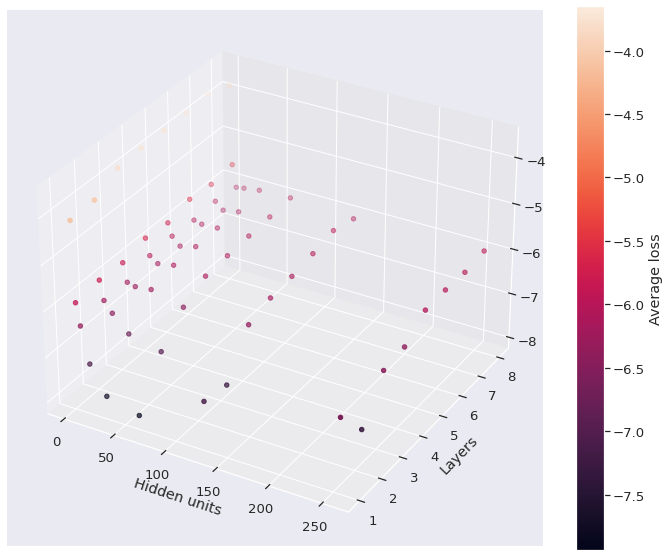

In [19]:
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average loss', fname='param_search_log_ff')

###  2. Learning with best parameter

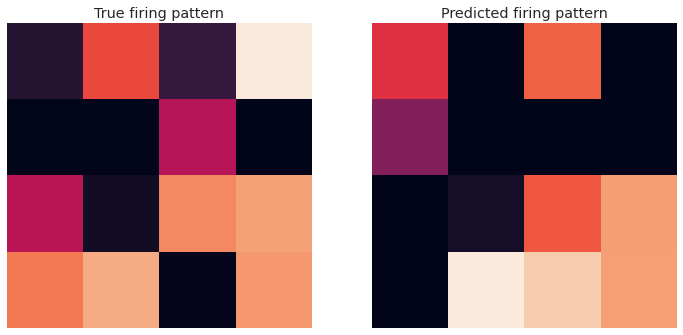

Initial eval loss: 0.044456690549850464
Epoch 1: training loss 0.06559038162231445, eval loss 0.002629304362926632. Time elapsed: 0 h 0 m 0 s.
Epoch 2: training loss 0.01680389017565176, eval loss 0.0009220289211953059. Time elapsed: 0 h 0 m 0 s.
Epoch 3: training loss 0.0062454748986056075, eval loss 0.0004177562514087185. Time elapsed: 0 h 0 m 0 s.
Epoch 4: training loss 0.00321386897485354, eval loss 0.00025369159993715584. Time elapsed: 0 h 0 m 0 s.
Epoch 5: training loss 0.002127827385265846, eval loss 0.00018422844732413068. Time elapsed: 0 h 0 m 0 s.
Epoch 6: training loss 0.0015995436315279221, eval loss 0.00014664496302430052. Time elapsed: 0 h 0 m 0 s.
Epoch 7: training loss 0.001292401260798215, eval loss 0.00012024455827486236. Time elapsed: 0 h 0 m 0 s.
Epoch 8: training loss 0.0010914556860370794, eval loss 0.00010372464566898998. Time elapsed: 0 h 0 m 0 s.
Epoch 9: training loss 0.000955644925852539, eval loss 9.13826243049698e-05. Time elapsed: 0 h 0 m 0 s.
Epoch 10: tr

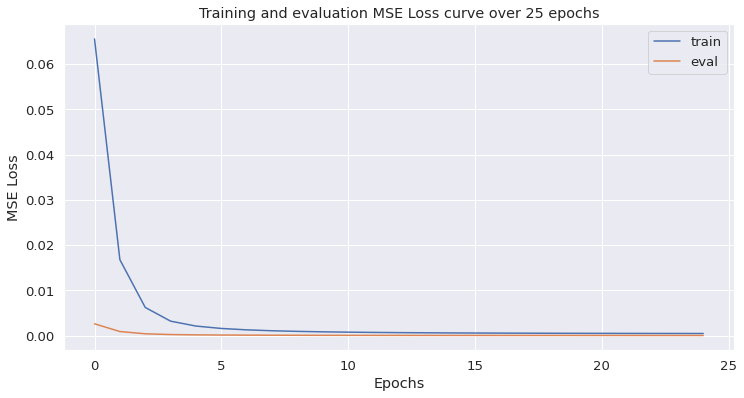

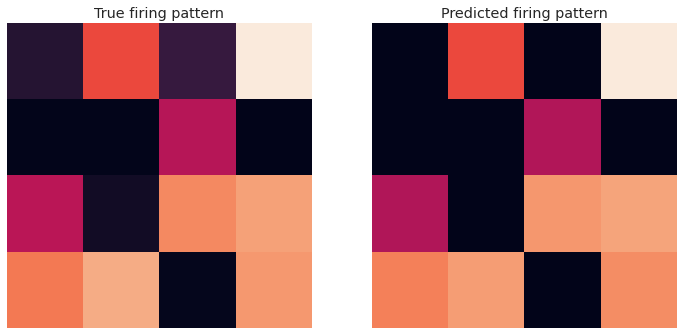

In [18]:
v_idx = np.random.randint(0, len(Y_test)) # a random label in the test set to visualise

# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=64, n_layers=1, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()    

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=n_epochs,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss')

visualise_prediction(Y_test[v_idx,:], DNN(X_test[v_idx,:])) # visualise after training

### 3. Testing against predicting the mean